In [57]:
import autograd.numpy as np
from autograd import grad

In [58]:
import pickle
import sys
import time 

def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # need for python 3
  return d

dataset="1"
#cfile = "../data/cam/cam" + dataset + ".p"
#ifile = "../data/imu/imuRaw" + dataset + ".p"
#vfile = "../data/vicon/viconRot" + dataset + ".p"

cfile = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR1//data/cam/cam" + dataset + ".p"
ifile = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR1//data/imu/imuRaw" + dataset + ".p"
vfile = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR1//data/vicon/viconRot" + dataset + ".p"


ts = tic()
camd = read_data(cfile)
imud = read_data(ifile)
vicd = read_data(vfile)
toc(ts,"Data import")

Data import took: 2.0156970024108887 sec.



In [59]:
from transforms3d.euler import mat2euler

#print(vicd)
#print(vicd['rots'].shape)
ts = vicd['ts']
print(ts[:,0])
rots = vicd['rots']
#print("rots;", rots)
N_r = vicd['rots'].shape[2]
print("N_r = ", N_r)
print(rots[:,:,1].shape)


euler0 = mat2euler(rots[:,:,0])
print("euler", euler0)

roll = []
pitch = []
yaw = []
timestamps = []
for i in range(N_r):
    #euler = mat2euler(rots[:,:,i],'szyx')
    euler = mat2euler(rots[:,:,i],)
    euler_deg = np.degrees(euler)
    roll.append(euler_deg[0])
    pitch.append(euler_deg[1])
    yaw.append(euler_deg[2])
    timestamps.append(ts[:,i])
print(len(roll))
  

[1.29663678e+09]
N_r =  5561
(3, 3)
euler (-0.0016304305382098825, -0.011250113844923547, 0.004558270054145085)
5561


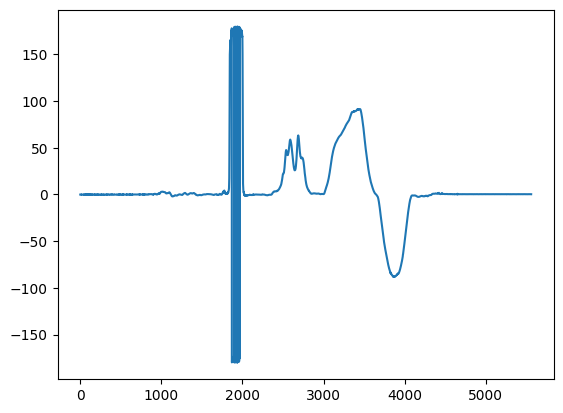

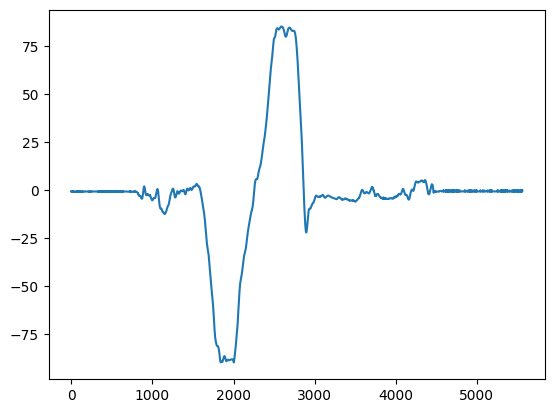

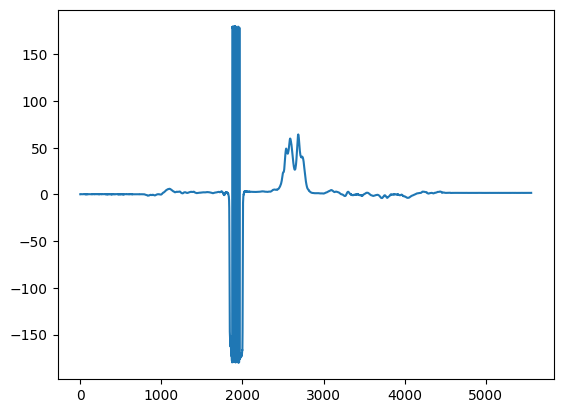

In [60]:
import matplotlib.pyplot as plt

plt.plot(roll)
plt.show()
plt.plot(pitch)
plt.show()
plt.plot(yaw)
plt.show()

In [61]:
#Imu calibration
print(imud)
print(imud['vals'].shape)

Vref = 3300 #mV
gyro_sensitivity = 3.33 #mV/deg/s
acc_sensitivity = 300 #mV/g
max_AD_val = 1023

gyro_scale_factor = (Vref/max_AD_val)*(np.pi/180)/gyro_sensitivity #rad/s
acc_scale_factor = Vref/max_AD_val/acc_sensitivity #g

print("gyro_scale_factor:",gyro_scale_factor)
print("acc_scale_factor:",acc_scale_factor)


#biases
stationary_frames = 700 #seen form plotting the vicon data
biases = []
for i in range(imud['vals'].shape[0]):
    b = sum(imud['vals'][i,:stationary_frames])/stationary_frames #mean of stationary frame values from imu
    b
    biases.append(b)

print("biases",biases)


{'vals': array([[511, 511, 511, ..., 511, 511, 511],
       [501, 501, 501, ..., 500, 500, 500],
       [605, 605, 606, ..., 605, 605, 606],
       [370, 369, 370, ..., 369, 369, 369],
       [374, 373, 374, ..., 373, 374, 373],
       [376, 376, 375, ..., 375, 376, 375]], dtype=uint16), 'ts': array([[1.29663678e+09, 1.29663678e+09, 1.29663678e+09, ...,
        1.29663684e+09, 1.29663684e+09, 1.29663684e+09]])}
(6, 5645)
gyro_scale_factor: 0.01690719027409018
acc_scale_factor: 0.01075268817204301
biases [510.8071428571429, 500.9942857142857, 605.1585714285715, 369.6857142857143, 373.57142857142856, 375.37285714285713]


In [62]:
#convert from AD to physical units 

print(imud['vals'][0,:].shape)
print(imud['vals'].shape)
#minus for x and y as IMU Ax and Ay direction is flipped (due to device design), so positive acceleration in
#body frame will result in negative acceleration reported by the IMU.
Ax = -(imud['vals'][0,:] - biases[0])*acc_scale_factor
Ay = -(imud['vals'][1,:] - biases[1])*acc_scale_factor
V_g = 1/acc_scale_factor
Az_bias = biases[2]-V_g
Az = (imud['vals'][2,:] - Az_bias) * acc_scale_factor #Az = V_g+V_bias
#Az = (imud['vals'][2,:] - biases[2]) * acc_scale_factor
print(imud['vals'][2,:])
Wz = (imud['vals'][3,:] - biases[3])*gyro_scale_factor
Wx = (imud['vals'][4,:] - biases[4])*gyro_scale_factor
Wy = (imud['vals'][5,:] - biases[5])*gyro_scale_factor

print("Ax",Ax)
print("Ay",Ay)
print("Az",Az)
print("Wz",Wz)
print("Wx",Wx)
print("Wy",Wy)



(5645,)
(6, 5645)
[605 605 606 ... 605 605 606]
Ax [-0.00207373 -0.00207373 -0.00207373 ... -0.00207373 -0.00207373
 -0.00207373]
Ay [-6.14439324e-05 -6.14439324e-05 -6.14439324e-05 ...  1.06912442e-02
  1.06912442e-02  1.06912442e-02]
Az [0.99829493 0.99829493 1.00904762 ... 0.99829493 0.99829493 1.00904762]
Wz [ 0.00531369 -0.0115935   0.00531369 ... -0.0115935  -0.0115935
 -0.0115935 ]
Wx [ 0.00724594 -0.00966125  0.00724594 ... -0.00966125  0.00724594
 -0.00966125]
Wy [ 0.01060322  0.01060322 -0.00630397 ... -0.00630397  0.01060322
 -0.00630397]


In [63]:

def q_exp(q):
    exp = np.zeros(4)
    q_s = q[0]
    q_v = q[1:]
    q_v_norm = np.linalg.norm(q_v)
    if q_v_norm > 0:
        exp[0] = np.exp(q_s)*np.cos(q_v_norm)
        exp[1:] = np.exp(q_s)* (q_v/q_v_norm)*np.sin(q_v_norm)
    else: 
        exp[0] = np.exp(q_s)
    return exp



def q_multiplication(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return np.array([w, x, y, z])







In [64]:
n = imud['vals'].shape[1]
q_0 = np.array([1,0,0,0])
q = []
#print(imud['ts'][:,0][0])
#print(Wx[0])
q.append(q_0)
for t in range(1,n):
    #if t == 0:
        #Tau_t = imud['ts'][:,t][0]
        #q_t = q_0 
    
    #else: 
        #Tau_t = imud['ts'][:,t][0] - imud['ts'][:,t-1][0]
        #q_t = q[t-1]
    Tau_t = imud['ts'][:,t][0] - imud['ts'][:,t-1][0]
    q_t = q[t-1]
    print(Tau_t)
    #print((Tau_t*Wx[t])/2)
    #print(np.array([0,(Tau_t*Wx[t])/2,(Tau_t*Wy[t])/2,(Tau_t*Wz[t])/2],dtype=object))
    exp_expression = np.array([0,(Tau_t*Wx[t])/2,(Tau_t*Wy[t])/2,(Tau_t*Wz[t])/2],dtype=object)
    rot_change = q_exp(exp_expression)
    #print(rot_change)
    q_t_p_1 = q_multiplication(q_t,rot_change)
    q.append(q_t_p_1)
q = np.array(q)

print(q)
        



0.009810924530029297
0.010303974151611328
0.009565114974975586
0.010580062866210938
0.009521961212158203
0.010577917098999023
0.00952005386352539
0.010601043701171875
0.009528875350952148
0.009798049926757812
0.010586977005004883
0.009413957595825195
0.010591983795166016
0.009552955627441406
0.010613203048706055
0.009533882141113281
0.010582923889160156
0.009527206420898438
0.01057887077331543
0.00952291488647461
0.009859085083007812
0.010008096694946289
0.009943962097167969
0.010444879531860352
0.009469985961914062
0.010575056076049805
0.009528160095214844
0.010587930679321289
0.009525060653686523
0.010593891143798828
0.009534120559692383
0.009511947631835938
0.010575056076049805
0.00951385498046875
0.01058506965637207
0.009516000747680664
0.010568857192993164
0.009523153305053711
0.010545015335083008
0.009536027908325195
0.010587930679321289
0.009475946426391602
0.010586977005004883
0.009536027908325195
0.010535955429077148
0.009525060653686523
0.009521961212158203
0.0105800628662109

In [65]:
from transforms3d.euler import quat2euler
e_roll = []
e_pitch = []
e_yaw = []
for qt in q:
    euler = quat2euler(qt)
    euler = np.degrees(euler)
    e_roll.append(euler[0])
    e_pitch.append(euler[1])
    e_yaw.append(euler[2])

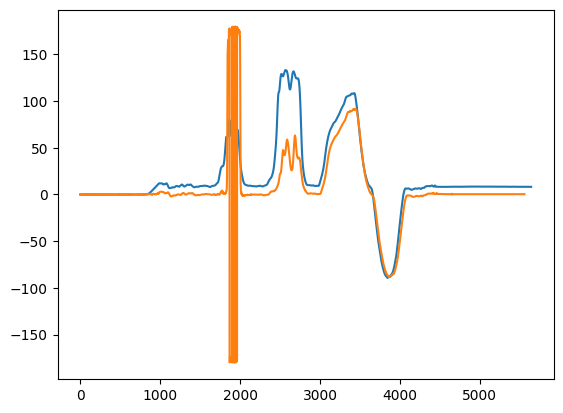

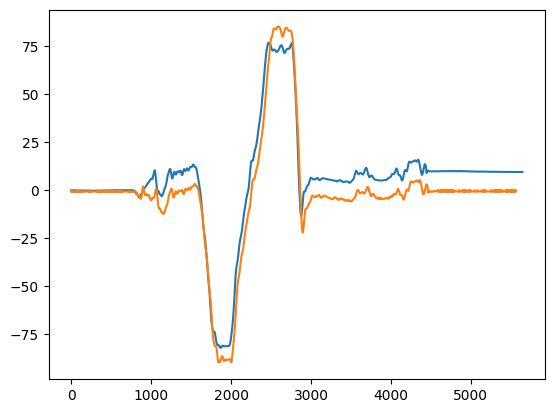

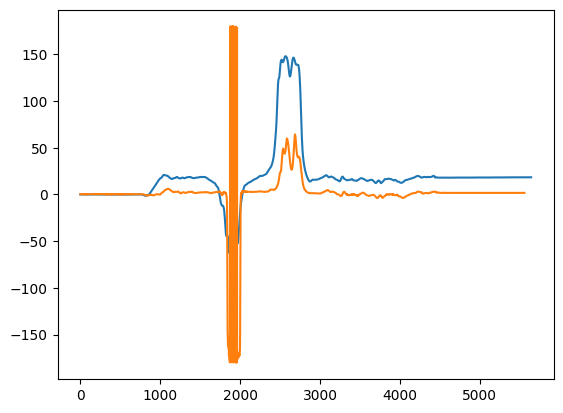

In [66]:
plt.plot(e_roll)
plt.plot(roll)
plt.show()

plt.plot(e_pitch)
plt.plot(pitch)
plt.show()

plt.plot(e_yaw)
plt.plot(yaw)
plt.show()

In [67]:
#Quaternions operation for observation model
def q_conjugation(q):
    q_conj = np.array([q[0],-q[1],-q[2],-q[2]])
    return q_conj

def q_norm(q):
    q_n = np.sqrt(q[0]**2+q[1]**2+q[2]**2+q[3]**2)
    return q_n

def q_inv(q):
    q_i = q_conjugation(q)/(q_norm(q)**2)
    return q_i

#quaternions operations for optimization
def q_log(q):
    q_s, q_x,q_y,q_z = q[0],q[1],q[2],q[3]
    q_v_norm = np.sqrt(q_x**2+q_y**2+q_z**2)
    if q_v_norm == 0:
        q_1_log = np.array([q_s])
        q_log = np.array([q_1_log,0,0,0])
        return q_log
    t = np.arctan2(q_v_norm,q_s)
    c = t/q_v_norm
    q_log = np.array([np.log(np.sqrt(q_s**2+q_v_norm**2)),c*q_x,c*q_y,c*q_z])
    return q_log
        

In [68]:

#observation model

g = 1

a = []
for qt in q:
    aceleration = np.array([0,0,0,-g])
    mult1 = q_multiplication(q_inv(qt),aceleration)
    at = q_multiplication(mult1,qt)
    a.append(at)
    



In [69]:
#quaternions operations for optimization using autograd
def q_norm1(q):
    s = np.sum(np.square(q),axis = -1)
    q_n = np.sqrt(s)
    return q_n

def q_exp1(q):
    #s = np.sum(q[..., 1:]**2,axis = -1,keepdims = True)
    sqrt = np.sqrt(np.sum(q[..., 1:]**2,axis = -1,keepdims = True))
    tolerance = 1e-08
    a = np.where(sqrt<tolerance,tolerance,sqrt)
    s_exp = np.exp(q[...,0:1])
    v_exp = np.concatenate([np.sin(a)/a,np.cos(a)/a],axis = -1)
    exp1 = np.concatenate([s_exp*v_exp[...,0:1],s_exp*v_exp[...,1:]*q[...,1:]],axis=-1)
    return exp1

def q_multiplication1(q1,q2):
    q1_s,q1_x, q1_y,q1_z = np.split(q1,4,axis=-1)
    q2_s,q2_x, q2_y,q2_z = np.split(q2,4,axis=-1)
    q_s = q1_s*q2_s - q1_x*q2_x -q1_y*q2_y-q1_z*q2_z
    q_x = q1_s*q2_x + q1_x*q2_s +q1_y*q2_z-q1_z*q2_y
    q_y = q1_s*q2_y + q1_y*q2_s+q1_z*q2_x-q1_x*q2_z
    q_z = q1_s*q2_z+q1_z*q2_s+q1_x*q2_y-q1_y*q2_x
    q_mult = np.concatenate([q_s,q_x,q_y,q_z],axis=-1)
    return q_mult

def q_inv1(q):
    q_norm1 = np.sum(q**2,axis = -1,keepdims = True)
    q_i = np.concatenate([(q[...,0:1])/q_norm1,(-q[...,1:])/q_norm1],axis=-1)
    return q_i

def q_log1(q):
    q_l1 = np.empty((0,4))
    for q_i in q:
        q_s, q_x,q_y,q_z = q_i[0],q_i[1],q_i[2],q_i[3]
        q_v_norm = np.sqrt(q_x**2+q_y**2+q_z**2)
        tol = 1e-06
        if q_v_norm  < tol:
            q_1_log = np.array([q_s])
            q_log = np.array([q_1_log,tol,tol,tol])
        else:
            t = np.arctan2(q_v_norm,q_s)
            c = t/q_v_norm
            q_log = np.array([np.log(np.sqrt(q_s**2+q_v_norm**2)),c*q_x,c*q_y,c*q_z])
        q_l1 = np.vstack((q_l1,q_log))
    return q_l1

def q_norms(qs):
    q_ns = np.array([q_norm1(q) for q in qs])
    return q_ns





In [70]:
#optimization model

#making omega, a and tau 
omega = np.array([Wx,Wy,Wz]).T
a = np.array([Ax,Ay,Az]).T
tau = imud['ts'][0]

def f_t(q_t,tau_t,omega_t):
    tau_t = np.expand_dims(tau_t,axis = -1)/2
    o_0 = np.zeros((omega_t.shape[0],1))
    tau_omega = np.column_stack((o_0, tau_t*omega_t))
    exp = q_exp1(tau_omega)
    f = q_multiplication1(exp,q_t)
    return f

def h(q):
    g = -1
    n = q.shape[0]
    a = np.array([0,0,0,-g])
    a = np.tile(a,(n,1))
    a = a.reshape(n,4)
    q_inv = q_inv1(q)
    q_a = q_multiplication1(q_inv,a)
    h = q_multiplication1(q_a,q)
    return h


#function for each sum in the cost function
def exp1_err(q,tau,omega):
    f = f_t(q[1:],tau[1:],omega[1:])
    q_i = q_inv1(f)
    expr = q_multiplication1(q_i,f)
    log = q_log1(expr)
    expr2 = q_norms(2*log)
    exp1 = 0.5*np.sum(expr2**2)
    return exp1
   
def exp2_err(q,a):
    h1 = h(q)
    a = np.insert(a,0,0,axis = 1)
    err = a-h1
    exp = np.linalg.norm(err,axis = 1)
    l = exp.shape[0]
    norm = exp[1:l]
    exp2 = 0.5*np.sum(norm**2)
    return exp2

#cost function
def cost(q,tau,omega,a):
    cost_func = exp1_err(q,tau,omega) + exp2_err(q,a)
    return cost_func
    

In [71]:

from autograd import grad
#new q 

n = imud['vals'].shape[1]
q_0 = np.array([1,0,0,0])
q1 = []

q1.append(q_0)
for t in range(1,n):
   
    Tau_t = imud['ts'][:,t] - imud['ts'][:,t-1]
    q_t = q1[t-1]
    
    exp_expression = np.array([0,(Tau_t*Wx[t])/2,(Tau_t*Wy[t])/2,(Tau_t*Wz[t])/2],dtype=object)
    rot_change = q_exp(exp_expression)
    #print(rot_change)
    q_t_p_1 = q_multiplication(q_t,rot_change)
    q1.append(q_t_p_1)
q1 = np.array(q1)

grad_cost = grad(cost)

grad1 = grad_cost(q,tau,omega,a)
print(grad1.shape)
        

(5645, 4)


In [72]:
def grad_descent(q,tau,omega,a):
    step_size = 0.1
    itr = 10
    conv_tol = 1e-06
    T = q.shape[0]
    grad_cost = grad(cost)
    for i in range(itr):
        grad_i = grad_cost(q,tau,omega,a)
        q = q-step_size * grad_i
        #normalize
        for j in range(T):
            q[j] = q[j]/q_norm(q[j])
        cost_val = cost(q,tau,omega,a)
        print("cost function value: ", np.abs(cost_val))
        print("iteration:", i)

        #covergence
        if np.abs(cost_val) < conv_tol:
            break
    q_optim = q
    return q_optim


In [73]:
q_o = grad_descent(q1,tau,omega,a)
print(q_o)

cost function value:  11343.697589926127
iteration: 0
cost function value:  11315.5621575305
iteration: 1
cost function value:  11305.819197051556
iteration: 2
cost function value:  11302.432951237055
iteration: 3
cost function value:  11301.247492123633
iteration: 4
cost function value:  11300.8288445031
iteration: 5
cost function value:  11300.679565580558
iteration: 6
cost function value:  11300.625777837151
iteration: 7
cost function value:  11300.606177069849
iteration: 8
cost function value:  11300.5989464162
iteration: 9
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.99999465e-01 -3.08173631e-05  1.03260356e-03 -5.68241207e-05]
 [ 9.99999477e-01 -3.03003057e-05  1.02183128e-03 -2.94861292e-05]
 ...
 [ 9.87937945e-01  5.44931974e-03  2.41818311e-03  1.54735494e-01]
 [ 9.87947301e-01  5.44958033e-03  2.41828200e-03  1.54675738e-01]
 [ 9.87956542e-01  5.37291134e-03  2.35911001e-03  1.54620302e-01]]


In [74]:
from transforms3d.euler import quat2euler
o_roll = []
o_pitch = []
o_yaw = []
for qt in q_o:
    euler = quat2euler(qt)
    euler = np.degrees(euler)
    o_roll.append(euler[0])
    o_pitch.append(euler[1])
    o_yaw.append(euler[2])

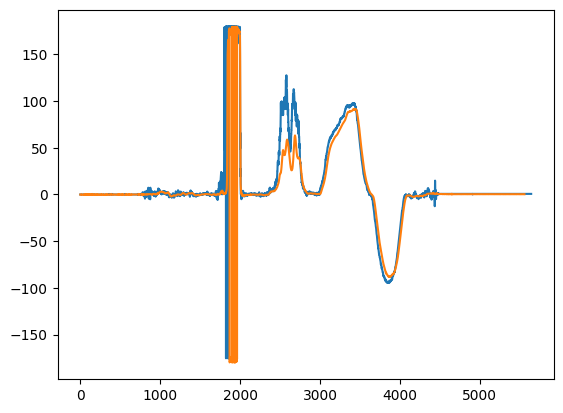

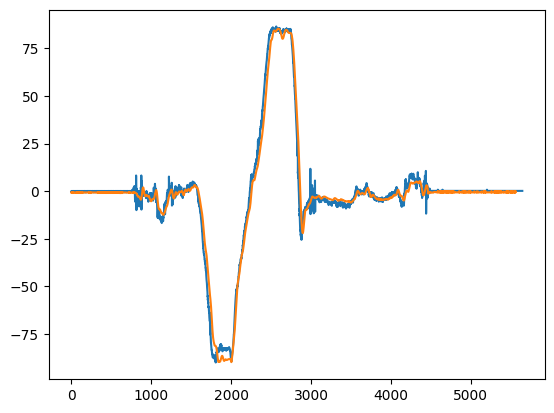

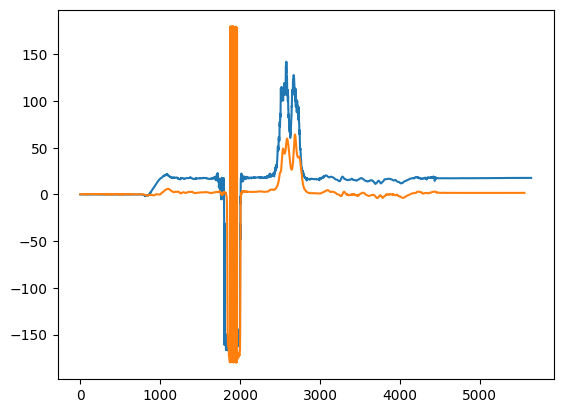

In [75]:
plt.plot(o_roll)
plt.plot(roll)
plt.show()

plt.plot(o_pitch)
plt.plot(pitch)
plt.show()

plt.plot(o_yaw)
plt.plot(yaw)
plt.show()

In [76]:
def plot(roll,est_roll,pitch,est_pitch,yaw,est_yaw,dataset_name):
    f,(fig1,fig2,fig3) = plt.subplots(3,1,figsize=(20,15))
    f.suptitle("Trainingset " + dataset_name)

    fig1.set_title("Roll")
    fig1.set_xlim(0,len(est_roll))
    fig1.plot(est_roll, label = 'Estimated roll')
    fig1.plot(roll,label = "Vicon ground truth")
    fig1.legend()

    fig2.set_title("Pitch")
    fig2.set_xlim(0,len(est_pitch))
    fig2.plot(est_pitch, label = 'Estimated pitch')
    fig2.plot(pitch,label = "Vicon ground truth")
    fig2.legend()

    fig3.set_title("Yaw")
    fig3.set_xlim(0,len(est_yaw))
    fig3.plot(est_yaw, label = 'Estimated yaw')
    fig3.plot(yaw,label = "Vicon ground truth")
    fig3.legend()

    plt.tight_layout()
    plt.show()


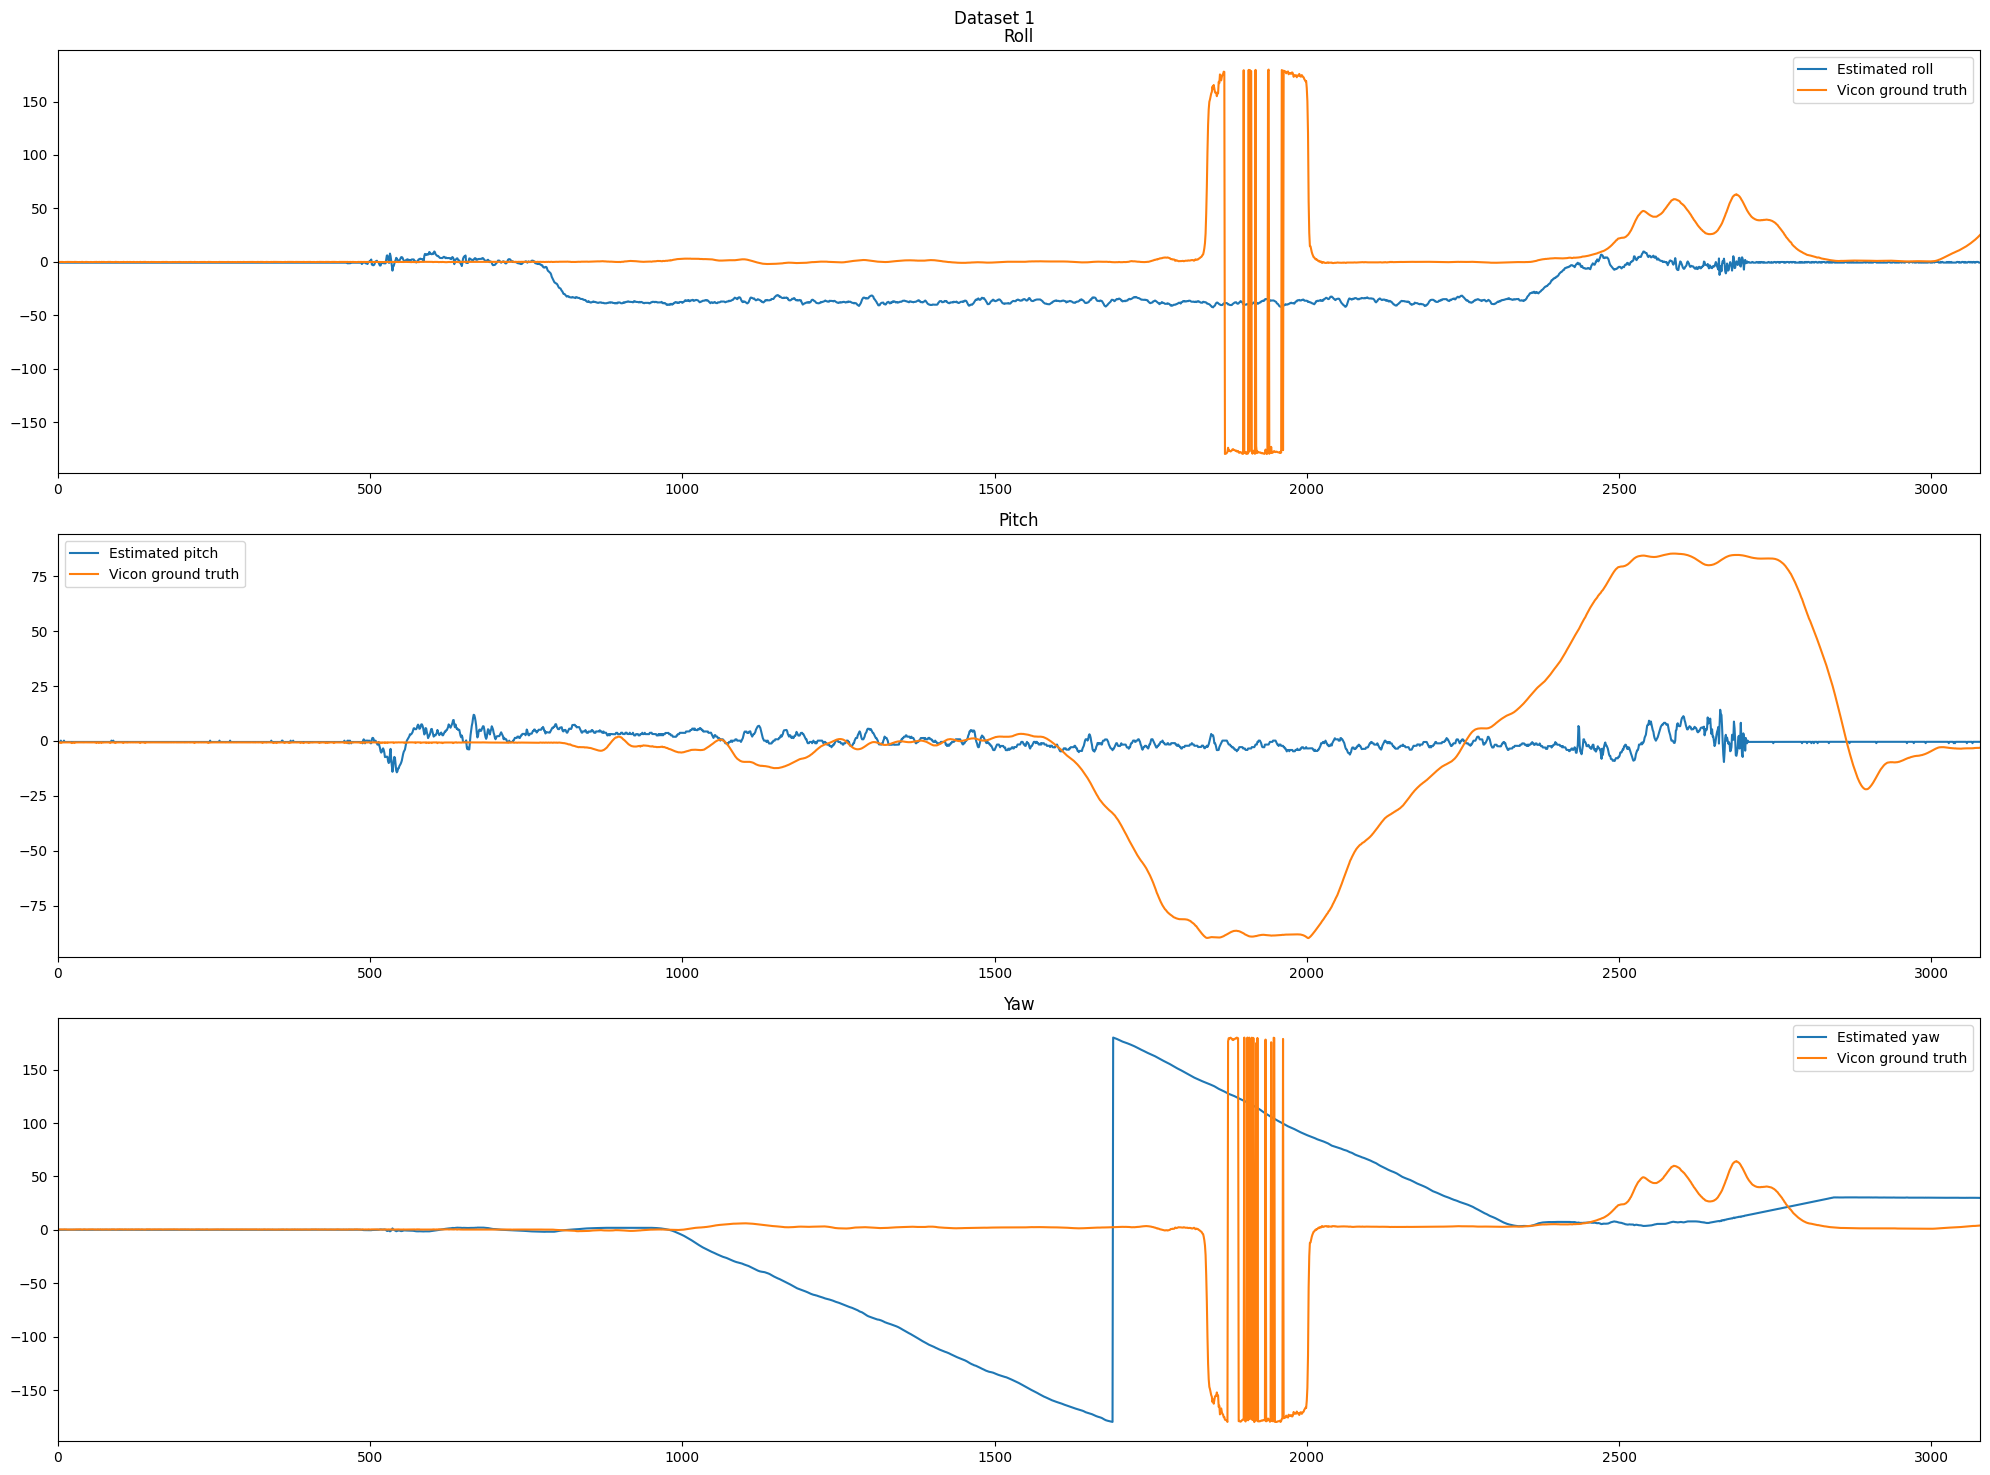

In [56]:
plot(roll,o_roll,pitch,o_pitch,yaw,o_yaw,dataset)

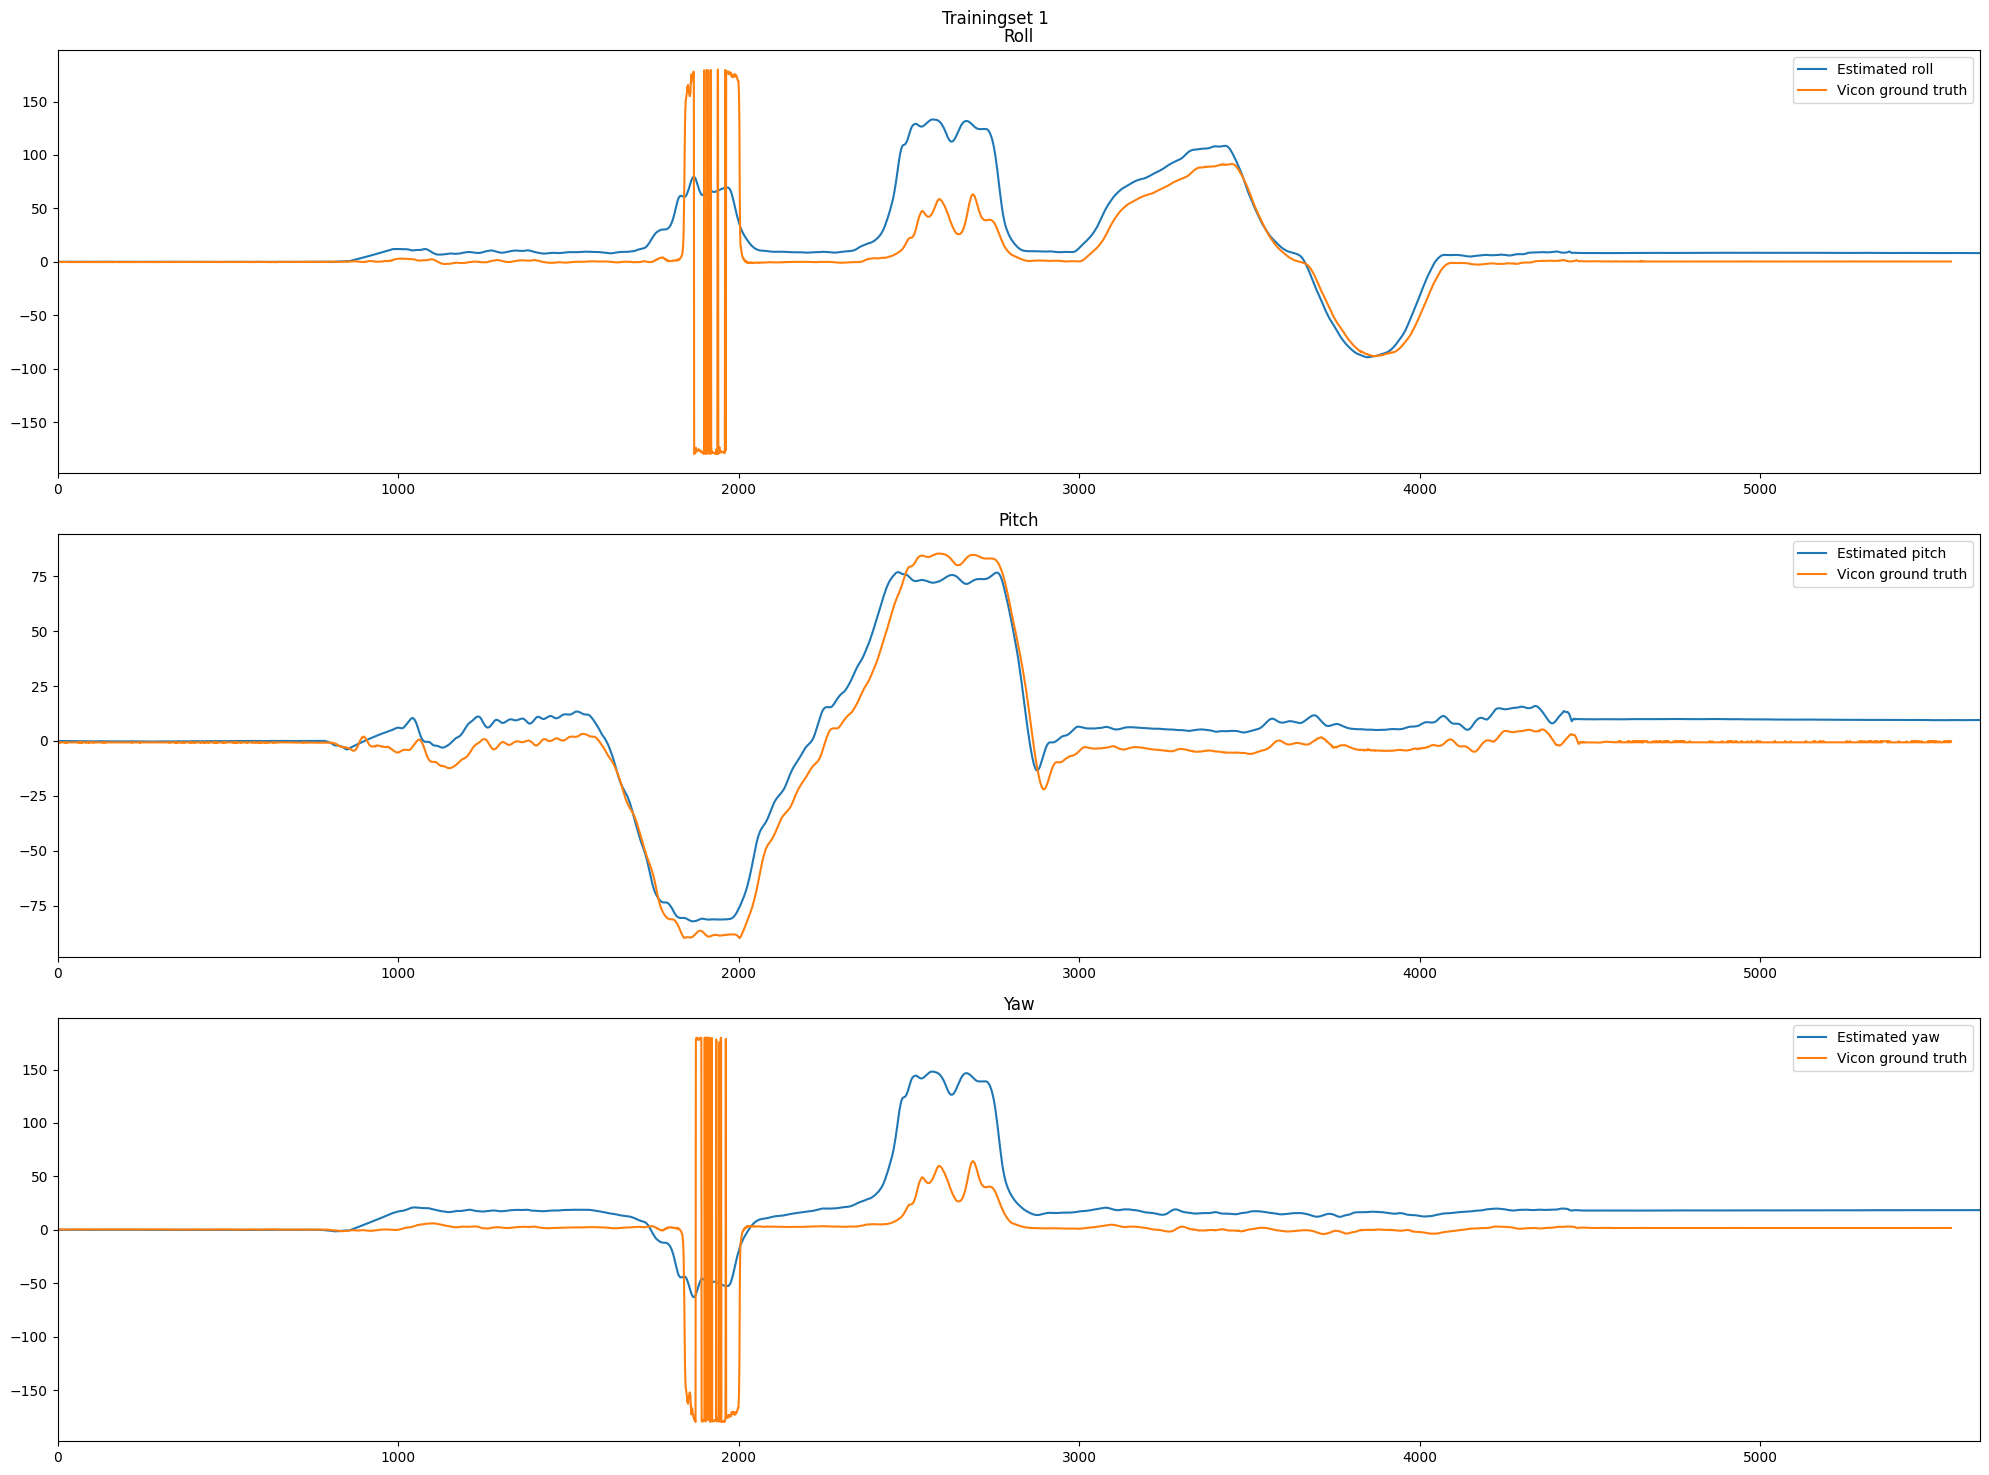

In [77]:
plot(roll,e_roll,pitch,e_pitch,yaw,e_yaw,dataset)